In [1]:
from functools import partial

from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Run the following before any XLA modules such as JAX:
import chex

chex.set_n_cpu_devices(2)

import sys
sys.path.append("../src")

# Import the remaining JAX related 
from gabenet.mcmc import sample_markov_chain
from gabenet.nets import MultinomialDirichletBelieve

import haiku as hk
import jax

2023-09-29 09:19:47.150714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


To illustrate how to use the multinomial-Dirichlet believe network, we will train the
model on the UCI ML datasets, containing handwritten digits.

The dataset can directly be loaded from scikit-learn. As preprocessing step, we reshape the
digits from a 8x8 square matrix to a flat array of size 64.

In [2]:
digits = datasets.load_digits()
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
X_train, X_test = train_test_split(X, test_size=0.2, random_state=0)

In [6]:
# Pseudo-random number generator sequence.
key_seq = hk.PRNGSequence(42)

m_samples, n_features = X_train.shape

@hk.transform_with_state
def kernel(X=X_train):
    """Advance the Markov chain by one step."""
    n_hidden_units = (2, 10)
    model = MultinomialDirichletBelieve(n_hidden_units, n_features)
    # Do one Gibbs sampling step.
    model(X)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
params, state = kernel.init(next(key_seq))

/home/hylke/workspace/gabenet/examples/../src/gabenet/random.py:326: UserWarning: Explicitly requested dtype float64 requested in zeros_like is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x_jk = jnp.zeros_like(b.transpose(), dtype=x.dtype)
/home/hylke/workspace/gabenet/examples/../src/gabenet/random.py:350: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x_pad = jnp.zeros((n_pad, x.shape[1]), x.dtype)


In [10]:
import jax.numpy as jnp
from jax.tree_util import tree_map

tree_map(jnp.shape, state)

{'multinomial_dirichlet_believe/~/cap_layer': {'c': (),
  'm_k': (2,),
  'r': (2,),
  'theta': (1437, 2)},
 'multinomial_dirichlet_believe/~/dirichlet_layer': {'c': (),
  'copy[theta(t+1)]': (1437, 2),
  'm': (1437, 10),
  'phi': (2, 10),
  'theta': (1437, 10)},
 'multinomial_dirichlet_believe/~/multinomial_layer': {'copy[theta(1)]': (1437,
   10),
  'phi': (10, 64)}}

In [11]:
apply_fn = jax.jit(kernel.apply)
_, state = apply_fn(params, state, next(key_seq))
# Warm up the JIT.
_ = state['multinomial_dirichlet_believe/~/multinomial_layer']['phi'].block_until_ready()

/home/hylke/workspace/gabenet/examples/../src/gabenet/random.py:326: UserWarning: Explicitly requested dtype float64 requested in zeros_like is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x_jk = jnp.zeros_like(b.transpose(), dtype=x.dtype)
/home/hylke/workspace/gabenet/examples/../src/gabenet/random.py:350: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  x_pad = jnp.zeros((n_pad, x.shape[1]), x.dtype)


In [12]:
_, state = apply_fn(params, state, next(key_seq))
_ = state['multinomial_dirichlet_believe/~/multinomial_layer']['phi'].block_until_ready()

# To enter cluster and start container:
```bash
ssh tunnel+nibbler
cdl && cd jobs/digits
srun --cpus-per-task=8 --mem=16gb --nodes=1 --qos=interactive --time=03:00:00 --partition=gpu_a40 --gpus-per-node=4 --pty bash -i

OUTPUT_DIR=/groups/umcg-lifelines/tmp02/projects/ov21_0208/jobs/job-output/digits
INPUT_DIR=/groups/umcg-lifelines/tmp02/projects/ov21_0208/jobs/job-input/digits
GPU_IMAGE=/groups/umcg-lifelines/tmp02/projects/ov21_0208/jobs/apptainer/cuda_12_9815359f_20230922.sif
apptainer run --nv --bind "/local/${SLURM_JOB_ID}":"/local/${SLURM_JOB_ID}" --env ARTEFACT_DIR=/mnt/output/ --bind ${INPUT_DIR}:/job/ --bind "${OUTPUT_DIR}:/mnt/output/" ${GPU_IMAGE}
```

In [16]:
n_chains = jax.device_count()

params, states = sample_markov_chain(
    next(key_seq), 
    kernel=kernel, 
    n_samples=50, 
    n_burnin_steps=100, 
    n_chains=n_chains,
)

_ = states['multinomial_dirichlet_believe/~/multinomial_layer']['phi'].block_until_ready()

After training the model, we can inspect what the model has learned. Note that, instead of a single point estimate of the parameters, we've obtained a distribution. To visualise the parameters, we take for simplicity the median. Let's take a look at $\bm{\Phi}^{(1)}$, the weights of the first layer.

<Figure size 640x480 with 0 Axes>

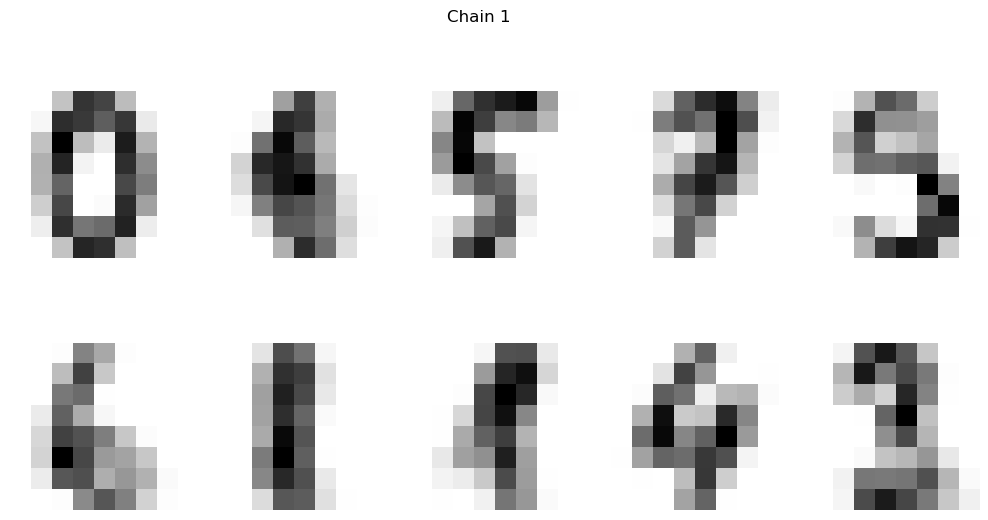

<Figure size 640x480 with 0 Axes>

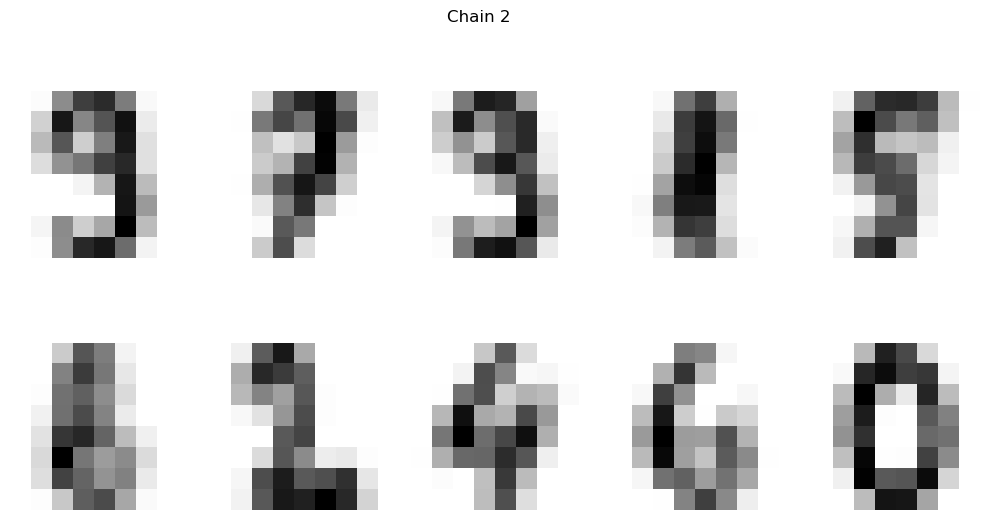

In [5]:
# Aggregate posterior samples to visualise.
phi_1st_layer = np.median(states['multinomial_dirichlet_believe/~/multinomial_layer']['phi'], axis=[1])

for i in range(n_chains):  # For each Markov chain.
    plt.figure()
    _, axes = plt.subplots(nrows=2, ncols=5, figsize=(12.5, 6))
    plt.suptitle(f'Chain {i+1}')
    # Plot the weights of all 10 hidden states.
    for ax, phi in zip(axes.flatten(), phi_1st_layer[i]):
        ax.set_axis_off()
        image = phi.reshape(8, 8)
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")